In [1]:
%matplotlib inline
from os import listdir
from os.path import isfile, join
import sys 
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.integrate import quad as int_quad

In [2]:
def residual(p,func, xvar, yvar, err):
    return (func(p, xvar) - yvar)/err

def fit_model(p, x):
    # p = [A, mu, sigma, m, b]
    A = p[0]
    mu = p[1]
    sigma = p[2]
    m = p[3]
    b = p[4]
    # model to be fitted
    return A*np.exp(-0.5*((x - mu)/sigma)**2) + m*x + b

def cs_fit_model(p, x):
    # p = [lambda]
    return np.exp(-1*p[0]*x)

class Analysis:
    # thickness expected in mm
    # expect Channel and Counts fields in data
    def __init__(self, filename, thickness, f=None, init_plot=False):
        # doing cut arbitrarily by eye here 
        # come up with better estimate for this
        if not f: self.file = sys.stdout
        else: self.file = f
        self.pf, self.pferr, self.chisq,self.dof = None, None, None, None
        self.fited = None
        self.thickness = thickness
        self.low = 480
        self.high = 600
        self.data_start = 1
        # self.data = [chan_arr, count_arr]
        self.data = np.loadtxt(filename , unpack=True, skiprows = self.data_start, delimiter = ",")  
        self.chan = self.data[0][self.low:self.high]
        self.N = self.data[1][self.low:self.high]
        self.dN = np.sqrt(self.N)
        # for any dN = 0, set dN = 1.14 (see justification for this)
        for i, value in enumerate(self.N):
            if value == 0: self.dN[i] = 1.14
        
        if init_plot:
            # make this nicer to get a single plot
            fig, ax = plt.subplots(figsize=(6,4))
            ax.errorbar(self.chan, self.N, self.dN, fmt='k.', capsize=3)
    
    # The code below defines our data fitting function.
    # Inputs are:
    # initial guess for parameters p0
    # the function we're fitting to
    # the x,y, and dy variables
    # tmi can be set to 1 or 2 if more intermediate data is needed

    def data_fit(self, p0,func,xvar, yvar, err,tmi=0):
        try:
            fit = optimize.least_squares(residual, p0, args=(func,xvar, yvar, err),verbose=tmi)
        except Exception as error:
            print("Something has gone wrong:",error, file=self.file)
            return p0,np.zeros_like(p0),-1,-1
        self.pf = fit['x']

        print(" ", file=self.file)

        try:
            cov = np.linalg.inv(fit['jac'].T.dot(fit['jac']))          
            # This computes a covariance matrix by finding the inverse of the Jacobian times its transpose
            # We need this to find the uncertainty in our fit parameters
        except:
            # If the fit failed, print the reason
            print('Fit did not converge', file=f)
            print('Result is likely a local minimum', file=self.file)
            print('Try changing initial values', file=self.file)
            print('Status code:', fit['status'], file=self.file)
            print(fit['message'], file=self.file)
            return self.pf,np.zeros_like(self.pf),-1,-1
            #You'll be able to plot with this, but it will not be a good fit.

        self.chisq = sum(residual(self.pf,func,xvar, yvar, err) **2)
        self.dof = len(xvar) - len(self.pf)
        self.red_chisq = self.chisq/self.dof
        self.pferr = np.sqrt(np.diagonal(cov)) # finds the uncertainty in fit parameters by squaring diagonal elements of the covariance matrix
        print('Thickness: ' + self.thickness, file=self.file)
        print('Converged with chi-squared {:.2f}'.format(self.chisq), file=self.file)
        print('Number of degrees of freedom, dof = {:.2f}'.format(self.dof), file=self.file)
        print('Reduced chi-squared {:.2f}'.format(self.red_chisq), file=self.file)
        print(" ", file=self.file)
        Columns = ["Parameter #","Initial guess values:", "Best fit values:", "Uncertainties in the best fit values:"]
        print('{:<11}'.format(Columns[0]),'|','{:<24}'.format(Columns[1]),"|",'{:<24}'.format(Columns[2]),"|",'{:<24}'.format(Columns[3]), file=self.file)
        for num in range(len(self.pf)):
            print('{:<11}'.format(num),'|','{:<24.3e}'.format(p0[num]),'|','{:<24.3e}'.format(self.pf[num]),'|','{:<24.3e}'.format(self.pferr[num]), file=self.file)
        return self.pf, self.pferr, self.chisq,self.dof
    
    def fit(self, p0, x):
        # returns fitted function evaluated on x
        # does not return a function
        if self.pf is None:
            self.pf, self.pferr, self.chisq, self.dof = self.data_fit(p0, fit_model, self.chan, self.N, self.dN)
        self.fited = fit_model(self.pf, x)
        return self.fited
    
    def compute_gamma_num(self, p0):
        # this does not subtract the background yet
        # NOTE: integration introduces error
        if self.pf is None:
            self.pf, _, _, _ = self.data_fit(p0, fit_model, self.chan, self.N, self.dN)
        self._fited = lambda x : fit_model(self.pf, x)
        self.N_Nerr = int_quad(self._fited, self.low, self.high)
        return self.N_Nerr
    
    def plot(self, p0, ax):
        # modifies axis object with data, lables and title
        # correctly styled
        X = np.linspace(self.chan.min(), self.chan.max(), 500)
        if self.fited is None or self.pf is None: self.fit(p0, X)

        if ax is None: ax = plt.gca() # get current axis
        
        ax.errorbar(self.chan, self.N, self.dN, fmt='ko', label = 'Data', capsize=1)
        ax.plot(X, self.fited, 'r-', label = 'Fit')

        ax.set_title('Thickness: '+self.thickness)
        ax.set_xlabel('Channel')
        ax.set_ylabel('Counts')

        # Here is the text we want to include...
        #textfit = '$f(x) = A/\\sigma \\sqrt{2\\pi} exp(\\frac{-(x - \\mu)^2}{2\\sigma^2}) + mx + b$ \n' 
        textfit = '$A = {:.2f} \pm {:.2f}$ \n'.format(self.pf[0],self.pferr[0]) 
        textfit +='$\\mu = {:.2f} \pm {:.2f}$ \n'.format(self.pf[1],self.pferr[1]) 
        textfit +='$\\sigma = {:.2f} \pm {:.2f}$ \n'.format(self.pf[2],self.pferr[2]) 
        textfit +='$m = {:.2f} \pm {:.2f}$ \n'.format(self.pf[3],self.pferr[3])
        textfit +='$b = {:.2f} \pm {:.2f}$ \n'.format(self.pf[4],self.pferr[4]) 

        textfit2 = '$\chi^2= {:.1f}$ \n'.format(self.chisq) 
        textfit2 += '$N = {}$ (dof) \n'.format(self.dof) 
        textfit2 += '$\chi^2/N = {:.2f}$'.format(self.chisq/self.dof) 

        #... and below is where we actually place it on the plot
        ax.text(0.60, 0.85, textfit, transform=ax.transAxes , fontsize=12,verticalalignment='top')
        ax.text(0.05, 0.95, textfit2, transform=ax.transAxes , fontsize=12,verticalalignment='top')


        ax.set_xlim([self.chan.min()-0.5, self.chan.max()+0.5])
        # this ensures that the axes always scale to be just slightly wider than the data.
        ax.legend(loc='upper right')
        return None

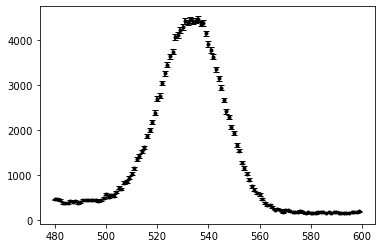

In [3]:
path = 'first_pass_data/2020_10_8/'
files = [f for f in listdir(path) if isfile(join(path, f))]

test = Analysis(path+files[0], files[0][:-4], init_plot=True)

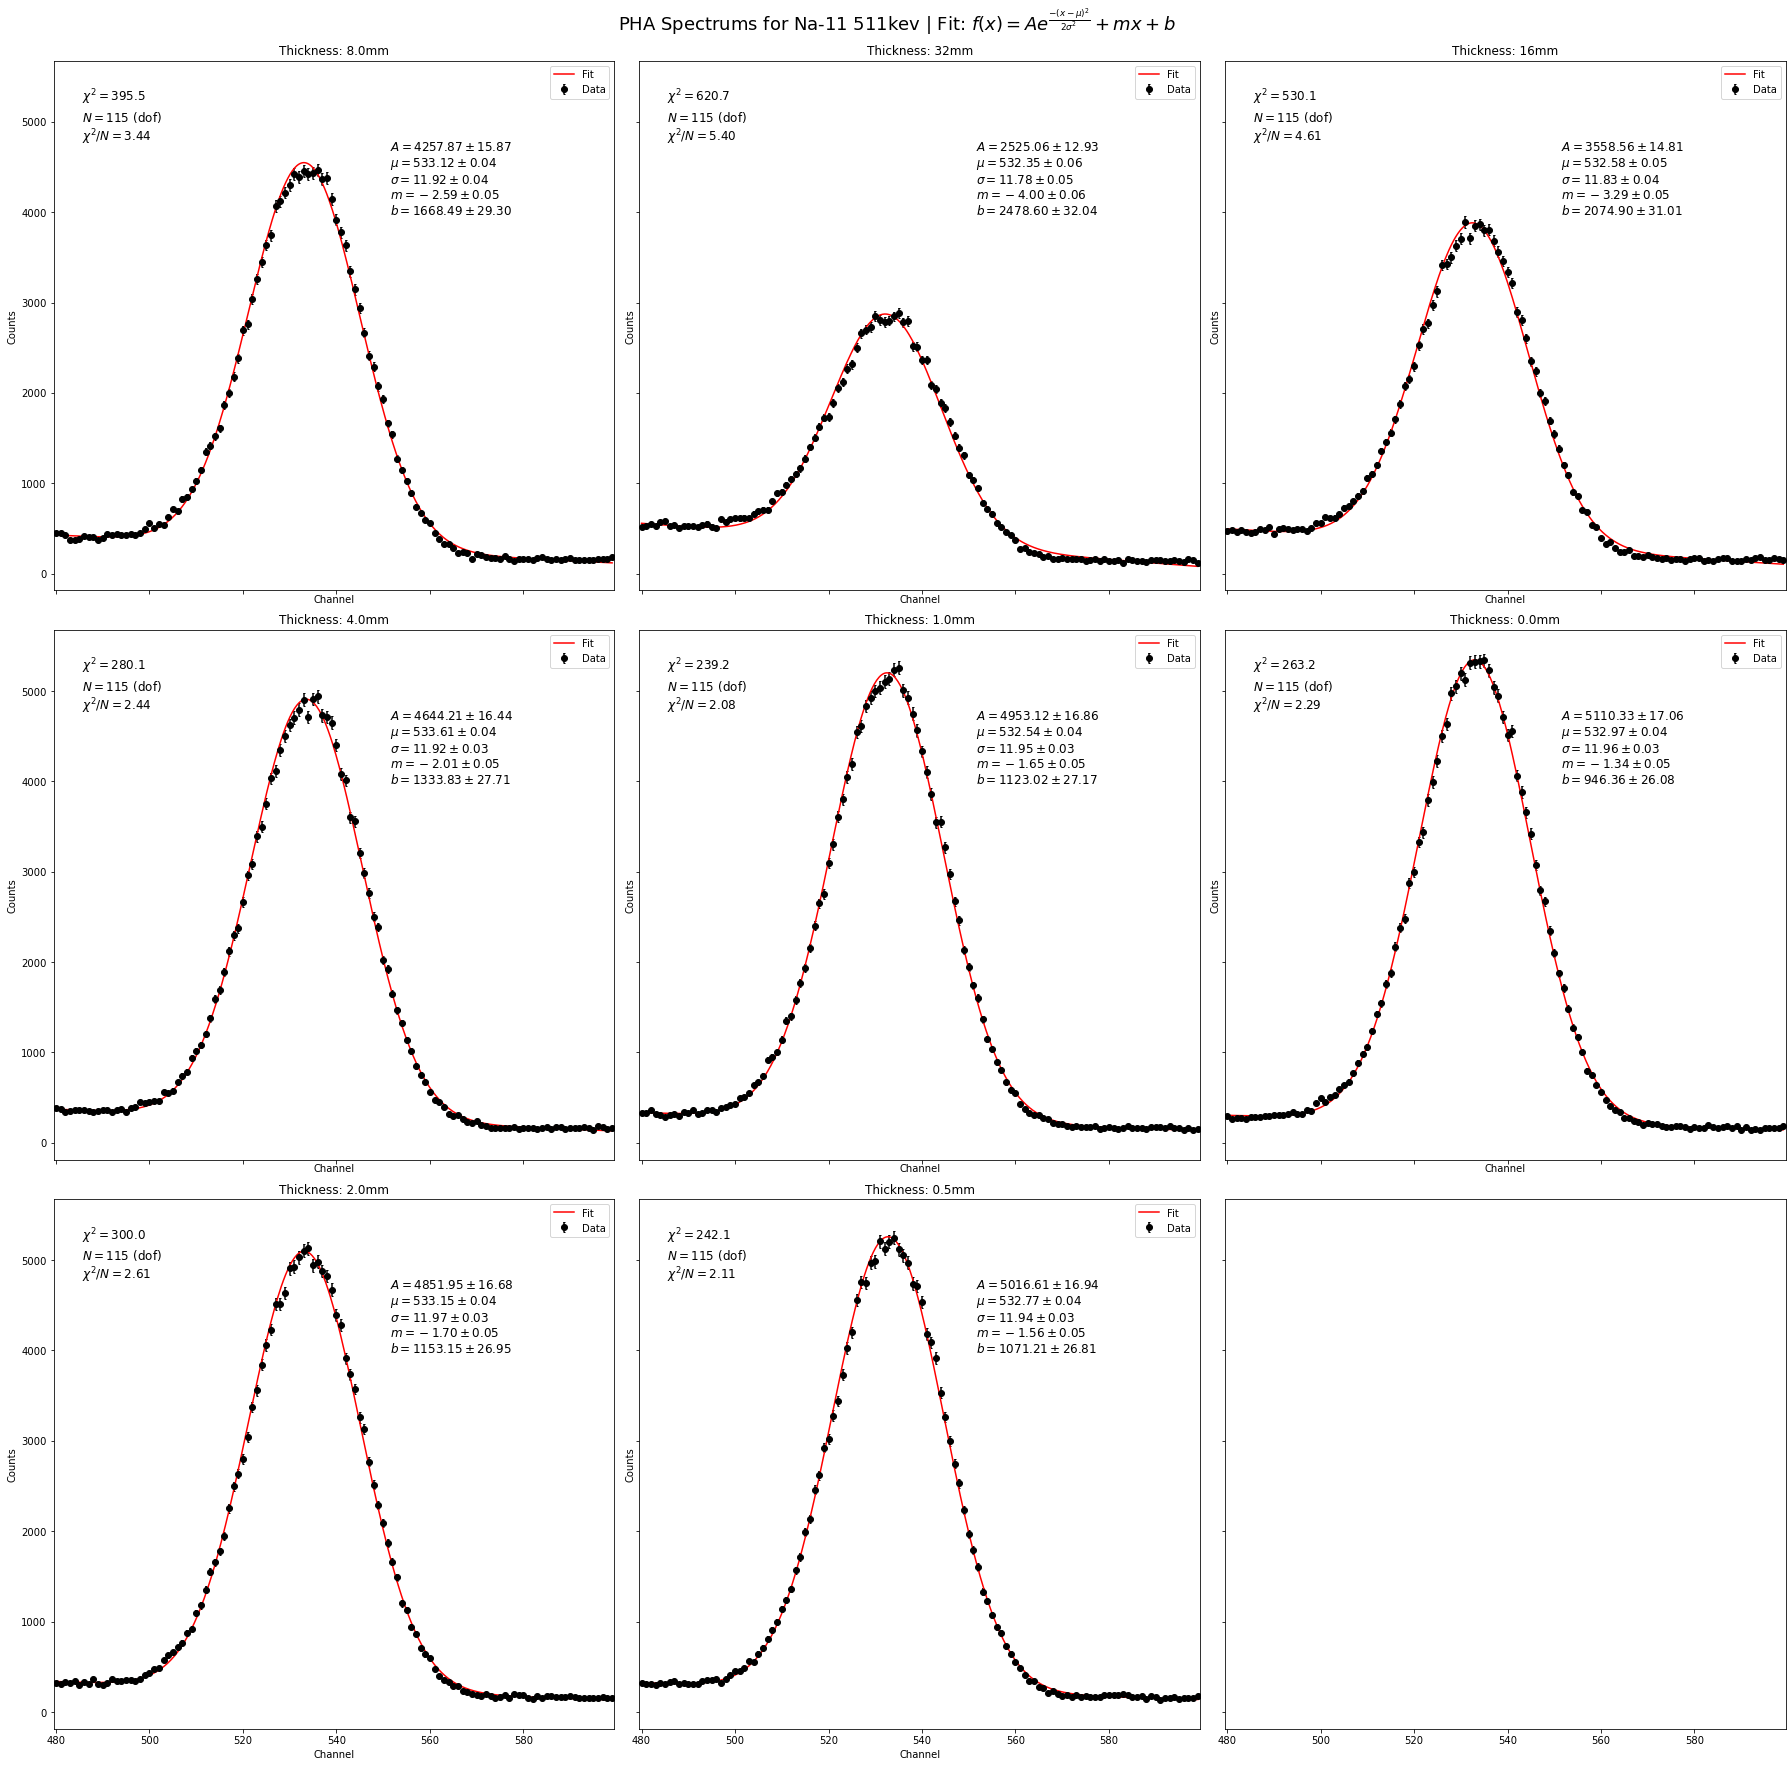

In [6]:
photon_nums = {} # thicknes : (nums, error (in integrating))
# p = [A, mu, sigma, m, b]
p0 = [5000, 530, 10, -0.5, 0.5] # init  param guess for fitting

# test fit params p0
#fig, ax = plt.subplots(figsize=(6,4))
#ax.plot(test.chan, fit_model(p0, test.chan), 'r-')
outfile = 'Na11_511kev.txt'
with open(outfile, "r") as f:
    data = f.read()

fig, axes = plt.subplots(ncols=3,nrows=3, sharex=True, sharey=True, figsize=(25,25))
with open(outfile, 'w') as f:
    for i, file in enumerate(files):
        thickness = file[:-4] # some slice
        analysis = Analysis(path+file, thickness, f)
        photon_nums[thickness] = analysis.compute_gamma_num(p0)
        ax = axes.flat[i] # get the ith axis and pass to plot method
        analysis.plot(p0, ax)

title = "PHA Spectrums for Na-11 511kev | Fit: $f(x) = Ae^{\\frac{-(x - \\mu)^2}{2\\sigma^2}} + mx + b$"
fig.suptitle(title, fontsize=18)
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.savefig("PHA_spectrums_for_Na-11_511kev.pdf")
plt.show()

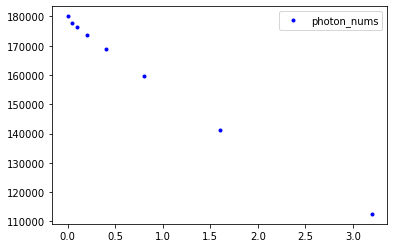

In [5]:
# can be used to get all params and num plots
thickness = [float(s[:-2]) / 10 for s in photon_nums.keys()]
nums = [s[0] for s in photon_nums.values()] 

fig, ax = plt.subplots(figsize=(6,4))
ax.plot(thickness, nums, 'b.', label='photon_nums')
ax.legend()